## Parsing Micron Sonar File from CSV format

In [97]:
import csv
import pandas as pd
import seaborn as sns 
import numpy as np
import scipy
import math
import datetime
import dateutil
from matplotlib import pyplot as plt 
from IPython.display import Image
sns.set()

###  Notes 
- pandas can successfully parse ~/Directory/Path but open function gets confused by the tilde
- Seanet-Dumplog manual gives information about what to expect for the columns (especially the headers)
- might need to parse each ping separately (number of bins could change from ping to ping when range settings are being changed, which will be expecially true when sonar is operating onboard the vehicle.
    - should make sure that pandas does not get upset when there are some rows that have different number of columns (could examine sonar behavior for maximum number of bins and just build arrays that are of that size?)
- employ Full-Width Half-Maximum principle [FWHM](https://en.wikipedia.org/wiki/Full_width_at_half_maximum)
- The sonar receiver has an 80dB dynamic range and signal levels are processed internally such that 0 to 80dB = 0 to 255 (full 80dB (8 bit)

### TODOs 
- convert `status` and `Hdctrl` to binary and process for status (reject values that are not OK
- implement `MicronEnsemble.py` 
- implement `MicronTimeSeries.py` 
    - make sure to think about how vehicle dynamics and vehicle dimensions effect the readings of the sonar (i.e. the pitch and the lever-arm of the vehicle)
- investigate why status value is 144? (if 144 is int -> 8 bits, if 144 is hex -> requires 9 bits) (call Tritech about this?)
- convert to standard metric values while parsing (make parsing function to handle this (similar to Pathfinder class))
- pass in year, month, and day values to the parser (data only has hours, minutes, seconds)
- `datetime.datetime.fromtimestamp(tmp)`
- trade-off between convolution filter and threshold intensity 
    - need to think carefully about this for devising an automate approach that works in all cases

In [223]:
dir_path = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/NSF Arctic NNA/Research Activities/2020-02-11_Saint-Fabien-Sonar-Testing/csv/"
file_name1 = "Tue_11_Feb_15_54.CSV"
file_name2 = "Tue_11_Feb_16_15.CSV"
file_name3 = "Thu_13_Feb_12_15.CSV"
file_name4 = "Thu_13_Feb_12_53.CSV"
test_file = dir_path + file_name2
test_file = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/NSF Arctic NNA/Research Activities/2020-01-24_WHOI-Tank-Sonar-Testing/csv/Fri_24_Jan_12_51.CSV"
test_file = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/NSF Arctic NNA/Research Activities/2020-01-23_Eel-Pond-Sonar-Testing/csv/Thu_23_Jan_13_13.CSV"
test_file = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/NSF Arctic NNA/Research Activities/2020-01-23_Eel-Pond-Sonar-Testing/csv/Thu_23_Jan_13_53.CSV"

In [214]:
# Image(filename='img/Tue_11_Feb_16_15.jpg')

In [215]:
int("8923", 16)
int("16", 16)
bin(int("16", 16))
bin(8923)

# 8923 hex -> 0b   1000 1001 0010 0011
# 8923 int -> 0b   0010 0010 1101 1011'

# 8967 hex -> 0b   1000 1001 0110 0111
# 8967 int -> 0b   0010 0011 0000 0111'

# 144  hex -> 0b 1 0100 0100
# 144  int -> 0b   1001 0000
# 16   hex -> 0b   0001 0110

# print(header[14], row1[14]) # column 14 is the number of data points in the scanline 
# print(header[15], row1[15]) # column 15 is the first value of an array DBytes long

'0b10001011011011'

In [216]:
class MicronEnsemble(object):
    def __init__(self):
        """TODO
        """
        pass
    
class MicronTimeSeries(object):
    def __init__(self):
        """TODO
        """
        self._ensemble_list = []
    
    def add_ensemble(self, ensemble):
        """TODO 
        """
        self._ensemble_list.append(ensemble.data_array)

    def to_dataframe(self):
        """TODO
        """
        ts     = np.array(self.ensemble_list)
        cols   = self.label_list
        t      = ts[:,0] # first column of the times series 
        index  = pd.DatetimeIndex([datetime.fromtimestamp(val) for val in t])

        # save to data-frame 
        self._df  = pd.DataFrame(data=ts, index=index, columns=cols)


In [229]:
# parse the header information from the first row of data
csvfile = open(test_file)
header = csvfile.readline().split(',')    
angle_delta    = 0
angle_previous = None
angles_plotted = set([])

# iterate over the CSV file
for line in csvfile:
    ensemble = csvfile.readline().split(',')
    if (len(ensemble) == 1):
        print('Blank Line')
        continue
    
    # Tue_11_Feb_16_15
    year,month,day = 2020,'Feb',11

    # get Dbytes from header 
    min_range     = 0.3
    header_len    = 15
    dbytes        = int(ensemble[header_len-1])
    header_vars   = header[:header_len]
    derived_vars  = ['BinSize',
                     'MaxIntensity',
                     'PeakStart',
                     'PeakStartDist',
                     'PeakEnd',
                     'PeakEndDist',
                     'PeakWidth']
    derived_len   = len(derived_vars)
    pre_bin_len   = header_len + derived_len


    # initialize bin labels and bin data list 
    bin_vars   = ["bin_" + str(i) for i in range(1,dbytes+1)]
    data_array = np.empty(len(header_vars) + len(derived_vars) + dbytes)


    # initialize label list and data lookup table
    label_list  = header_vars + derived_vars + bin_vars
    data_lookup = {}
    for i in range(len(label_list)):
        data_lookup[label_list[i]] = i


    # add header values to the data array 
    for i in range(len(header_vars)):
        if header[i] == 'SOf': 
            data_array[data_lookup[header[i]]] = 0
        elif header[i] == 'DateTime': 
            data_array[data_lookup[header[i]]] = dateutil.parser.parse(ensemble[i]).timestamp()
        else:
            data_array[data_lookup[header[i]]] = ensemble[i]

    # add intensity values to the data array 
    for i in range(dbytes):
        bin_val = ensemble[i+header_len]
        bin_label = 'bin_' + str(i+1)
        data_array[data_lookup[bin_label]] = float(bin_val)


    # compute header values to standard metric quantities 
    data_array[data_lookup['Rangescale']] *= 1/10     # [dm] -> [m]
    data_array[data_lookup['LeftLim']]    *= 360/6400 # [1/16 Gradians] -> [deg]
    data_array[data_lookup['RightLim']]   *= 360/6400 # [1/16 Gradians] -> [deg]
    data_array[data_lookup['Steps']]      *= 360/6400 # [1/16 Gradians] -> [deg]
    data_array[data_lookup['Bearing']]    *= 360/6400 # [1/16 Gradians] -> [deg]
    data_array[data_lookup['AdLow']]      *= 80/255   # [0,255] -> [0,80dB]
    data_array[data_lookup['AdSpan']]     *= 80/255   # [0,255] -> [0,80dB]
    data_array[pre_bin_len:]              *= 80/255   # [0,255] -> [0,80dB]
    
    
    # populate the derived quanities 
    data_array[data_lookup['BinSize']] = data_array[data_lookup['Rangescale']] / dbytes # [m]
    invalid_bin_index = math.ceil(min_range/data_array[data_lookup['BinSize']])
    data_array[pre_bin_len:pre_bin_len+invalid_bin_index] = 0
    data_array[data_lookup['MaxIntensity']] = np.max(data_array[pre_bin_len:])


    # get width of values that satisfy the threshold 
    #     - use FWHM principle 
    kernel   = np.ones(13)
    bin_data = pd.DataFrame(np.array(data_array[pre_bin_len:]))
    bin_roll = bin_data.rolling(10, center=True).mean().replace(np.nan, 0).to_numpy().flatten()
    bin_peak = np.array(bin_roll)
    bin_peak[bin_peak <  np.max(bin_roll) / 2] = 0
    bin_peak[bin_peak >= np.max(bin_roll) / 2] = 1


    peak_start = np.argmax(bin_peak==1)
    peak_end   = np.argmax(bin_peak[peak_start:]==0) + peak_start
    data_array[data_lookup['PeakStart']] = peak_start
    data_array[data_lookup['PeakEnd']]   = peak_end
    data_array[data_lookup['PeakWidth']] = (peak_end - peak_start) * data_array[data_lookup['BinSize']]
    data_array[data_lookup['PeakStartDist']] = peak_start * data_array[data_lookup['BinSize']]
    data_array[data_lookup['PeakEndDist']] = peak_end * data_array[data_lookup['BinSize']]

    # store current angle and rounded angle 
    angle_current         = data_array[data_lookup['Bearing']]
    angle_current_rounded = math.floor(angle_current/10)*10
    
    # compute the change in angle since a plot has been generated 
    if (not angle_previous): 
        angle_delta = 0
    else:  
        if angle_current - angle_previous > 0:
            angle_delta += angle_current - angle_previous 
        else: 
            angle_delta += angle_current+360 - angle_previous 
    
    # update previous angle 
    angle_previous = angle_current 
    print(angle_current)
    
    # generate plot for every 20 degrees, avoid replotting area already plotted
    if ((angle_current_rounded % 30 == 0) and 
        (angle_delta > 15) and 
        (angle_current_rounded not in angles_plotted)):
        angles_plotted.add(angle_current_rounded)
        angle_delta=0
    
    
    if False: 
        
        # plot the data 
        sns.set(font_scale = 1.5)
        fig, ax = plt.subplots(figsize=(15,8))
        ax.plot(bin_data, linewidth=3, alpha=0.5,  color='tab:blue')
        ax.plot(bin_roll, linewidth=3, linestyle='--', color='tab:blue')
        plt.axvspan(peak_start, peak_end, color='tab:purple', alpha=0.3)

        fig.suptitle('Micron Sonar Ensemble, Saint-Fabien QC, %i %s %i' % 
                     (day, month, year), fontsize=22, fontweight='bold')


        # # try getting this information into a separate text box
        # ax.text(0.05, 0.95, "Bearing: %i$^\circ$    Max Intensity: %ddB      Peak Width: %.2fm" % 
        #                     (data_array[data_lookup['Bearing']],
        #                      data_array[data_lookup['MaxIntensity']],
        #                      data_array[data_lookup['PeakWidth']]), 
        #         transform=ax.transAxes, bbox=dict(boxstyle="round", fc="none", ec="gray"))


        ax.set_title("Bearing: %i$^\circ$    Max Intensity: %ddB      Peak Width: %.2fm" % 
                   (data_array[data_lookup['Bearing']],
                    data_array[data_lookup['MaxIntensity']],
                    data_array[data_lookup['PeakWidth']]), fontsize=18)

        num_ticks = 11
        xticks = np.arange(0, data_array[data_lookup['Dbytes']], data_array[data_lookup['Dbytes']]/(num_ticks-1))
        xticks = np.append(xticks, data_array[data_lookup['Dbytes']])
        xtick_labels = ["%.1f" % (e*data_array[data_lookup['BinSize']]) for e in xticks]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)
        ax.set_xlabel('Distance from Transducer [m]')
        ax.set_ylabel('Intensity [dB]')
        ax.legend(['Intensity', 'Rolling Average', 'FWHM'], loc='best')
        plt.savefig("../figs/6-peak-filter-bearing-%d.png" % angle_current_rounded)
        plt.close()


    #     print(csv.readlines(test_file))
    #     readCSV = csv.reader(csvfile, delimiter=',')
    #     for row in readCSV:
    #         print(len(row))

    #     print("hello world")

356.96250000000003
349.7625
345.0375
349.7625
356.96250000000003
4.1625000000000005
11.3625
11.3625
4.1625000000000005
356.96250000000003
349.7625
345.0375
349.7625
356.96250000000003
4.1625000000000005
11.3625
11.3625
4.1625000000000005
356.96250000000003
349.7625
345.0375
349.7625
356.96250000000003
4.1625000000000005
11.3625
11.3625
4.1625000000000005
356.96250000000003
349.7625
345.0375
349.7625
356.96250000000003
4.1625000000000005
11.3625
11.3625
4.1625000000000005
356.96250000000003
349.7625
345.0375
349.7625
356.96250000000003
4.1625000000000005
11.3625
11.3625
4.1625000000000005
356.96250000000003
349.7625
345.0375
349.7625
356.96250000000003
4.1625000000000005
11.3625
11.3625
4.1625000000000005
356.96250000000003
349.7625
345.0375
349.7625
356.96250000000003
4.1625000000000005
11.3625
11.3625
4.1625000000000005
356.96250000000003
349.7625
345.0375
349.7625
356.96250000000003
4.1625000000000005
11.3625
11.3625
4.1625000000000005
356.96250000000003
349.7625
345.0375
349.7625
35

KeyboardInterrupt: 

In [230]:
print(data_array[data_lookup['LeftLim']])
print(data_array[data_lookup['RightLim']])

345.0375
14.9625


In [221]:
print(data_array[data_lookup['AdLow']])
print(data_array[data_lookup['AdSpan']])

7.8431372549019605
34.8235294117647


In [ ]:
print("Parsing Scan Status")
status = str(bin(144))[2:][::-1] # convert to little endian byte ordering 
if int(status[0]) == 0: print("  scan is OK")
else:                   print("  WARNING: scan not OK")
if int(status[4]) == 1: print("  data in 8-bit ADC mode")
if int(status[7]) == 1: print("  a messages is appended after the data record")
    
Hdctrl = bin(8967)[2:][::-1] # convert to little endian byte ordering 
Hdctrl

In [210]:
header_vars

['SOf',
 'DateTime',
 'Node',
 'Status',
 'Hdctrl',
 'Rangescale',
 'Gain',
 'Slope',
 'AdLow',
 'AdSpan',
 'LeftLim',
 'RightLim',
 'Steps',
 'Bearing',
 'Dbytes']

In [256]:
tmp_angles = np.linspace(0,2*np.pi,100)

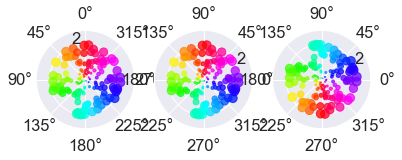

In [282]:
# Fixing random state for reproducibility
np.random.seed(19680801)

# Compute areas and colors
N = 150
r = 2 * np.random.rand(N)
theta = 2 * np.pi * np.random.rand(N)
area = 20 * r**2
colors = theta

theta_rot = theta + np.pi/2 % 360 

theta_flip = np.arctan2(-np.sin(theta_rot), np.cos(theta_rot))

# original data
fig = plt.figure()
ax = fig.add_subplot(131, projection='polar')
ax.set_theta_zero_location('N')
c = ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=0.75)

# rotation
ax = fig.add_subplot(132, projection='polar')
ax.set_theta_zero_location('E')
c = ax.scatter(theta_rot, r, c=colors, s=area, cmap='hsv', alpha=0.75)

# flip data 
ax = fig.add_subplot(133, projection='polar')
ax.set_theta_zero_location('E')
c = ax.scatter(theta_flip, r, c=colors, s=area, cmap='hsv', alpha=0.75)

In [288]:
bin(16971)[2:][::-1]

'110100100100001'

In [293]:
int('1101001001000010'[::-1],2)

16971